In [2]:
from google.colab import drive 
drive.mount('/content/drive')

#IMPORTS

import matplotlib.pyplot as plt
from PIL import Image as im
from skimage.color import rgb2gray
import cv2 as cv

from google.colab import files
import os
import math
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
#Defining Parameters for Image Conversion
scale = 4.5 #Scales the radii of the diffraction profiles (large scale increases space between 'rings')
resolution = 150#126*2 #Determines image resolution

In [15]:
#Uploading Bismuth Profiles

uploaded = files.upload()

Saving Bi_mp-23152_computed Profile_0.0.txt to Bi_mp-23152_computed Profile_0.0.txt
Saving Bi_mp-23152_computed Profile_0.1.txt to Bi_mp-23152_computed Profile_0.1.txt
Saving Bi_mp-23152_computed Profile_0.2.txt to Bi_mp-23152_computed Profile_0.2.txt
Saving Bi_mp-23152_computed Profile_0.3.txt to Bi_mp-23152_computed Profile_0.3.txt
Saving Bi_mp-23152_computed Profile_0.4.txt to Bi_mp-23152_computed Profile_0.4.txt
Saving Bi_mp-23152_computed Profile_0.5.txt to Bi_mp-23152_computed Profile_0.5.txt
Saving Bi_mp-23152_computed Profile_0.6.txt to Bi_mp-23152_computed Profile_0.6.txt
Saving Bi_mp-23152_computed Profile_0.7.txt to Bi_mp-23152_computed Profile_0.7.txt
Saving Bi_mp-23152_computed Profile_0.8.txt to Bi_mp-23152_computed Profile_0.8.txt
Saving Bi_mp-23152_computed Profile_0.9.txt to Bi_mp-23152_computed Profile_0.9.txt
Saving Bi_mp-23152_computed Profile_1.0.txt to Bi_mp-23152_computed Profile_1.0.txt


In [16]:
def generate_one_hot_vecs(num):
  #Generating one hot vectors for labels
  one_hot_vecs = []
  for i in range(0,num):
    one_hot_vec =[0] * num
    one_hot_vec[i] = 1
    one_hot_vecs.append(one_hot_vec)
  return one_hot_vecs

In [98]:
#Open and processes data in all files in a given directory
#Returns one list of radii and another of intensities
def retrieve_data(directory="Bi_mp-23152_computed Profile_"):
  #Creating an array of file names for all Bi files 
  files_to_open = []
  for val in range(0,11,1):
    #print(val/10)
    file_name = directory + str(val/10) + ".txt" 
    files_to_open.append(file_name)

  #Opening files and processing data into lists of radii and intensities 

  radii = [] 
  intensities = []

  for file_name in files_to_open:
    file = open(file_name, "r")
    array_vals = []
    for line in file:
      data_point = line.split() #X and Y values are separated by a space

      array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),float(data_point[1])]) #converts angles into radii  
    
    radius,intensity = zip(*array_vals) #Unzipping array of [x_values,y_values] into list of x_values and y_values
      
    radii.append(radius)
    intensities.append(intensity)
      
  for i in range(0,len(radii)):
    plt.plot(radii[i],intensities[i])

  return radii,intensities


In [134]:
#Converts Radii-Intensity data into Diffraction Patterns
#Returns 2D array in which each element is: [diffraction pattern, label]

def generate_diffraction_patterns(radii,intensities,one_hot_vecs,invert=False,num_augmentations=3,num_img_to_generate=5):

  #This code generates a two-part circular mask 
  #This mask obscures all points greater than a distance of 'curr_rad' and less than a distance of 'prev_rad'
  #This creates a circle, the radius of which depends on the resolution of the angle data
  #This mask is applied to a white image in order to generate a fully white circle 
  #source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
  #Added an invert option because it looks cool

  images = [] #images will be a list of [diffraction patterns, labels]

  #Setting up a (resolution,resolution) sized array for the mask
  #Ogrid is used to setup a row and column vector of values ranging from 0 to resolution

  Y,X = np.ogrid[:resolution,:resolution]
  centre_val = resolution/2

  #The values stored in each vector are squared and the vectors are added (using broadcasting)
  #The value at each point of the resulting array is the 'distance' between that point and the centre
  dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)

  #white image used to generate white circles
  #array_ones = np.ones((resolution,resolution))

  datagen = ImageDataGenerator(
    #zoom_range = 0.1,
    #rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    )

  for i in range(0,len(radii)): #iterates through all diffraction profiles
    
    #creates a 'base image' for the background of the image
    """
    if invert:
      base_img = np.ones((resolution,resolution))*255
    else:
      base_img = np.zeros((resolution,resolution))
    """
    
    base_img = np.zeros((resolution,resolution))
    radius = radii[i]
    intensity = intensities[i]
    
    #Scaling the radii of each diffraction pattern
    #This ensures that the smallest radii rings (the brightest rings) have a radius equal to 8.5% of the image's width/height
    min_rad = radius[0]
    radius_adjustment_value = (resolution/2)*0.17/min_rad

    prev_rad = radius[0]*radius_adjustment_value
    max_intensity = max(intensity)
    for j in range(0,len(radius)):   
      
      curr_rad = radius[j]*radius_adjustment_value
      
      #Defining the two-part mask
      mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)
      
      unscaled_circle = np.ones((resolution,resolution)) #np.copy(array_ones)
      
      #applies mask to white image
      unscaled_circle[~mask]=0
      
      #adds/subtracts the new circle to the base image depending on inversion
      """
      if invert:
        base_img -= unscaled_circle*intensity[j]*200/max_intensity #intensity values are scaled by the max intensity
      else:
        base_img += unscaled_circle*intensity[j]*200/max_intensity
      """
      base_img += unscaled_circle*intensity[j]*200/max_intensity
      prev_rad = curr_rad

    #standardizing image by setting max pixel value to 255
    max_image_brightness = max(np.ndarray.flatten(base_img))
    base_img = 255*base_img/max_image_brightness


    # Setting up stopper + bright spot
    X_centered = X - resolution/2
    Y_centered = Y - resolution/2

    #making x/y square arrays
    lin_combination_image = Y_centered+X_centered

    X_square = lin_combination_image-Y_centered
    Y_square = X_centered-lin_combination_image

    dist_from_center = (np.sqrt((X-centre_val)**2+(Y-centre_val)**2))

    max_dist = max(np.ndarray.flatten(dist_from_center))

    normalized_bright_spot = (max_dist-dist_from_center)/max_dist

    bright_spot_mask = (normalized_bright_spot>0.955) & (normalized_bright_spot<0.97)

    normalized_bright_spot[~bright_spot_mask] = 0

    normalized_bright_spot *= 255

    mask1 = (X_square>0)
    lin_eq_square =Y_square + 4*X_square

    mask = (lin_eq_square<resolution*0.04) & (lin_eq_square>-resolution*0.04) 
    unscaled_circle = 255*np.ones((resolution,resolution)) #np.copy(array_ones)

    #applies mask to white image
    unscaled_circle[~mask]=0
    unscaled_circle[~mask1]=0

    """
    if invert:
      base_img = np.clip(base_img + unscaled_circle - normalized_bright_spot,0,255)
      blurry_img = cv.GaussianBlur(base_img,(5,5),0)
      images.append([blurry_img,one_hot_vecs[i]])
      #No random translation for inverted image, because that leads to dark fringes around photo
      #This is because black space 
    """
    base_img = np.clip(base_img - unscaled_circle + normalized_bright_spot,0,255)

    #Blurring and randomly translating images to generate more datapoints        
    
    #We'll repeat the augmentation code multiple times, each time with a different blur

    for augmentation in range(0,num_augmentations):
      blurry_img = cv.GaussianBlur(base_img,(5,5),0.5+random.uniform(-0.5, 0.5))

      max_translation = int(0.05*resolution)
      for q in range(0,30):
        M = np.float32([
        [1, 0, random.randint(-max_translation,max_translation)],
        [0, 1, random.randint(-max_translation,max_translation)]
        ])    
        new_image = cv.warpAffine(blurry_img, M, (resolution,resolution))

        blurry_img_expanded=np.expand_dims(np.expand_dims(new_image,-1),0)

        num_images_generated = 0
        for augmented_image in datagen.flow(blurry_img_expanded):
          if num_images_generated < num_img_to_generate:
            num_images_generated+=1
            reshaped_augmented_image = np.reshape(augmented_image,(resolution,resolution)) 
            #reshaped_augmented_image = reshaped_augmented_image/np.max(reshaped_augmented_image)
            if invert:
              max_blurry_image_brightness = max(np.ndarray.flatten(reshaped_augmented_image))
              inverted_image = max_blurry_image_brightness - reshaped_augmented_image
              images.append([inverted_image,one_hot_vecs[i]])
            else:
              images.append([reshaped_augmented_image,one_hot_vecs[i]])
          else:
            break           
  #Shuffles dataset
  random.shuffle(images)
  #print(np.max(images[0][0]))
  return images

4950
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


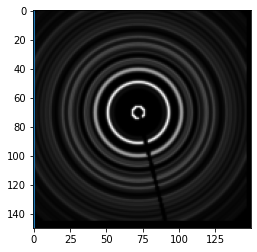

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


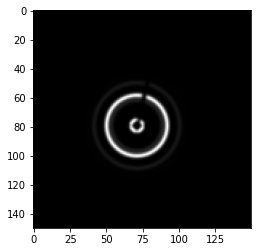

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


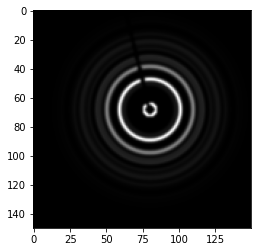

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


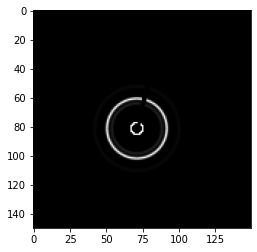

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


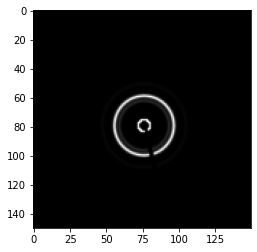

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


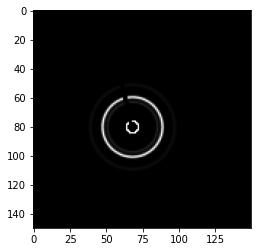

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


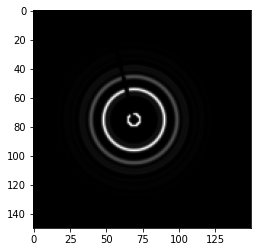

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


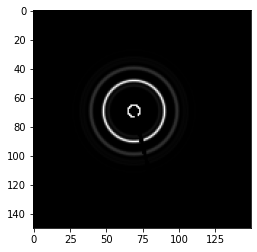

In [135]:
one_hot_vecs = generate_one_hot_vecs(11)
radii,intensities=retrieve_data("Bi_mp-23152_computed Profile_")
images = generate_diffraction_patterns(radii,intensities,one_hot_vecs,False)
print(len(images))
for i in range(0,8):
  plt.imshow(images[i][0],cmap='gray')
  print(images[i][1])
  plt.show()
  #print(max(np.ndarray.flatten(images[i][0])))

In [136]:
#Extracting and reshaping arrays of X and Y values from dataset

X,Y = zip(*images)

X_array = np.array(X).reshape(-1,int(resolution),int(resolution),1)
Y_array = np.array(Y).reshape(-1,11)

#Array shape is checked to ensure they are of equal length and of correct size
print(X_array.shape)
print(Y_array.shape)

(4950, 150, 150, 1)
(4950, 11)


In [137]:
#Defining neural net

def build_cnn_model():
  cnn_model = keras.Sequential([
      keras.layers.Conv2D(filters=18,kernel_size=(5,5),activation=tf.nn.relu),           
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=36,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Conv2D(filters=72,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),

      keras.layers.Flatten(),
      keras.layers.Dense(128, activation=tf.nn.relu),
      keras.layers.Dropout(0.6),
      
      keras.layers.Dense(11, activation=tf.nn.softmax)
  ])
    
  return cnn_model

In [138]:
#Building and compiling CNN

model = build_cnn_model()

#Defining a decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.05,
  decay_steps=10000,
  decay_rate=0.95)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

149/149 [==============================] - 2s 13ms/step - loss: 0.3922 - accuracy: 0.8379 - val_loss: 0.1035 - val_accuracy: 0.9717
SAVING NETWORK
149/149 [==============================] - 2s 13ms/step - loss: 0.2298 - accuracy: 0.8983 - val_loss: 0.0156 - val_accuracy: 1.0000
SAVING NETWORK
149/149 [==============================] - 2s 13ms/step - loss: 0.1921 - accuracy: 0.9203 - val_loss: 0.0191 - val_accuracy: 0.9960
SAVING NETWORK
149/149 [==============================] - 2s 14ms/step - loss: 0.1419 - accuracy: 0.9331 - val_loss: 0.0026 - val_accuracy: 1.0000
SAVING NETWORK
149/149 [==============================] - 2s 13ms/step - loss: 0.1453 - accuracy: 0.9338 - val_loss: 0.0031 - val_accuracy: 1.0000
SAVING NETWORK


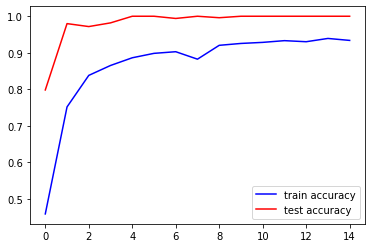

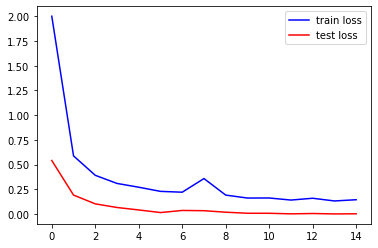

In [139]:
#Defining lists to store accuracy and loss values over the course of training 
accuracy_values = []
validation_accuracy_values= []
loss_values = []
validation_loss_values = []

EPOCHS = 15

#Training Neural Net
for epoch in range(1,EPOCHS+1):
  
  history = model.fit(X_array,Y_array,batch_size=30,epochs=1,validation_split=0.1)
  #Storing accuracy and loss values
  accuracy_values.append(history.history['accuracy'][0])
  validation_accuracy_values.append(history.history['val_accuracy'][0])
  loss_values.append(history.history['loss'][0])
  validation_loss_values.append(history.history['val_loss'][0])

  if epoch % 3 == 0:    
    print("SAVING NETWORK")
    weights_file_name = "/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_{}.ckpt".format(epoch)
    model.save_weights(weights_file_name)

#Plotting NN performance
f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)

ax1.plot(accuracy_values, "-b",label = "train accuracy")
ax1.plot(validation_accuracy_values, "-r",label = "test accuracy")
ax1.legend()
ax2 = f2.add_subplot(111)
ax2.plot(loss_values, "-b",label = "train loss")
ax2.plot(validation_loss_values, "-r",label = "test loss")
ax2.legend()




In [125]:

def load_model():
  model = build_cnn_model()
  model.load_weights("/content/drive/MyDrive/Bismuth_Data_Processed/CNN_weights_3.ckpt").expect_partial()
  return model

model = load_model()


In [140]:
def process_data(data_dir):
  data_dict = {}
  file_name_array = []
  for file in os.scandir(data_dir):
    #print(file.path)
    file_loc = file.path.split('Bismuth_Data_Processed')[1]
    if file_loc.endswith(".jpg"):      
      #if 'off' in file_loc.lower() or 'on' in file_loc.lower():
      if 'on' in file_loc.lower():
        photo = im.open(file.path)
        file_loc_cropped = file_loc.lower().strip().replace(' ','')
        #print(file_loc_cropped)
        #bw_photo_arr = rgb2gray(np.array(photo))
        photo_arr = rgb2gray(np.array(photo))
        normalized_photo_arr = photo_arr/np.max(photo_arr)
        #print(np.max(normalized_photo_arr))
        file_name_array.append(file_loc_cropped)

        data_dict[file_loc_cropped]=photo_arr#normalized_photo_arr
        #print(len(data_array))
  print("Done! Added {} images".format(len(data_dict.values())))
  return file_name_array, data_dict

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan0/
Done! Added 11 images


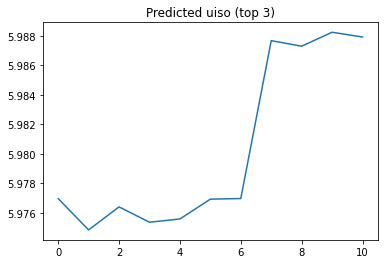

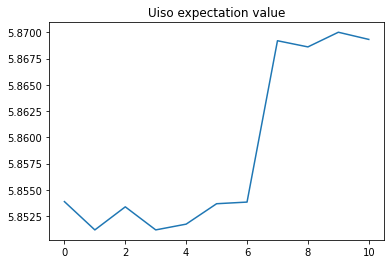

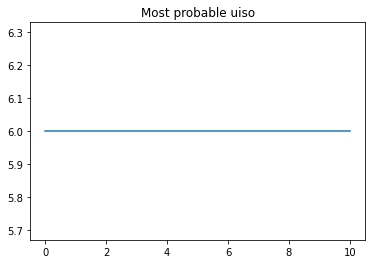

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan1/
Done! Added 11 images


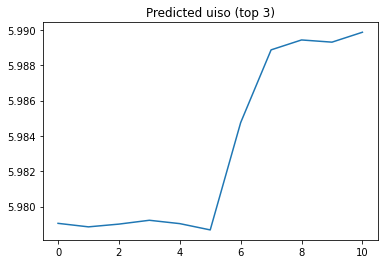

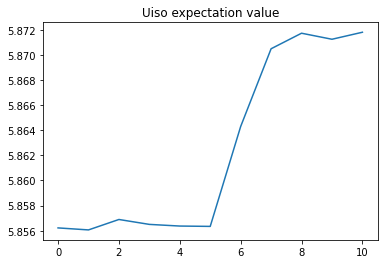

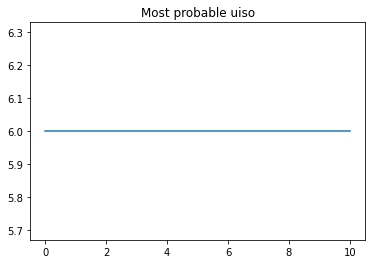

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan2/
Done! Added 21 images


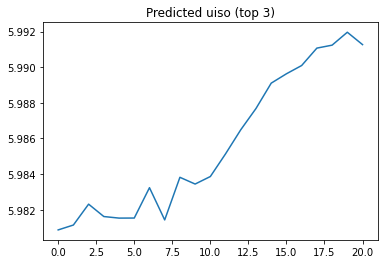

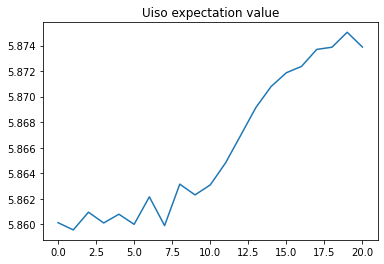

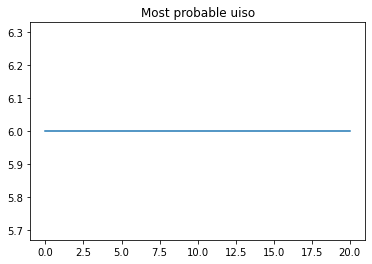

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan3/
Done! Added 41 images


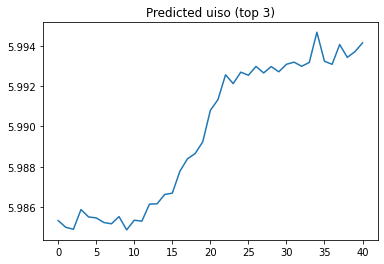

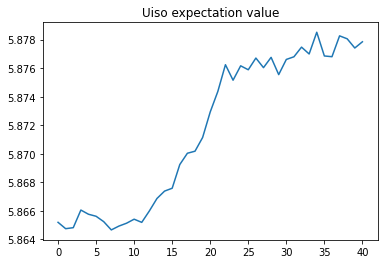

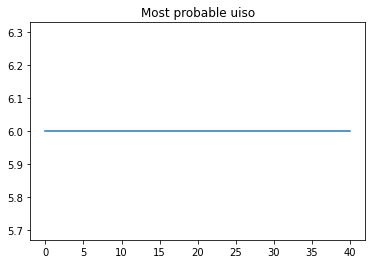

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan4/
Done! Added 51 images


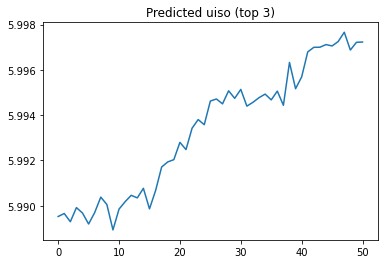

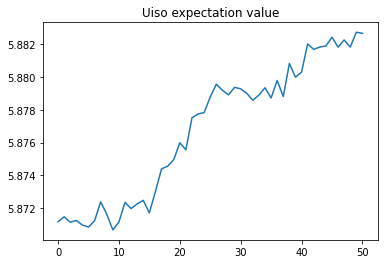

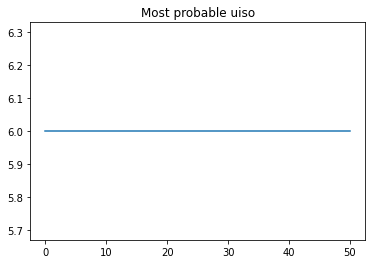

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan5/
Done! Added 11 images


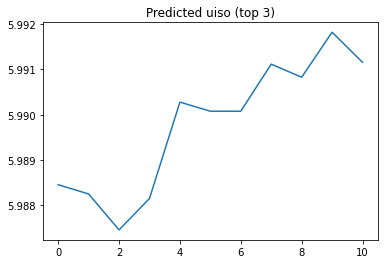

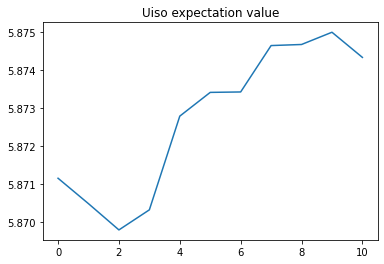

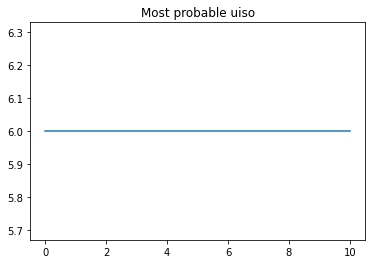

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan6/
Done! Added 41 images


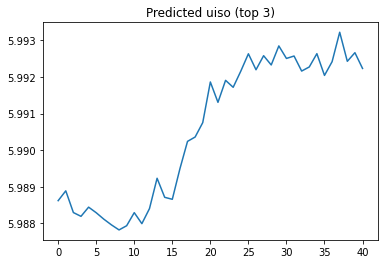

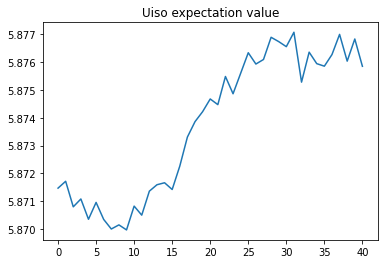

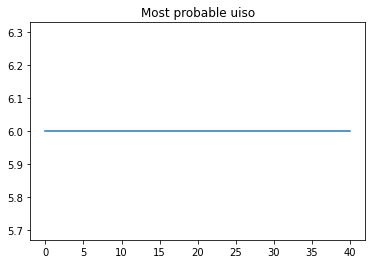

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan7/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan8/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan9/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan10/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan11/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan12/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan13/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-16/scans/scan14/
----------STARTING NEW TEST------
D

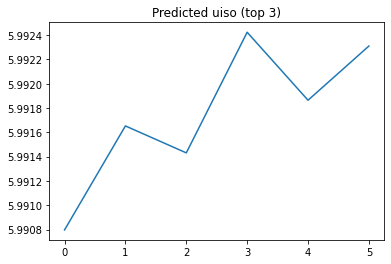

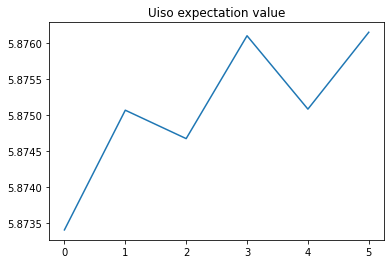

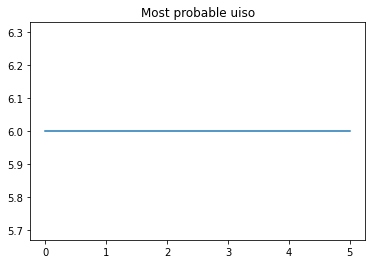

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan8/
Done! Added 40 images


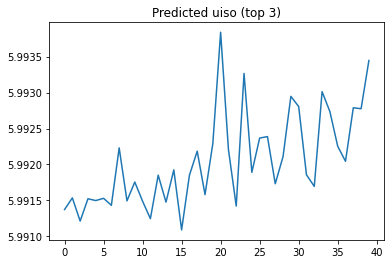

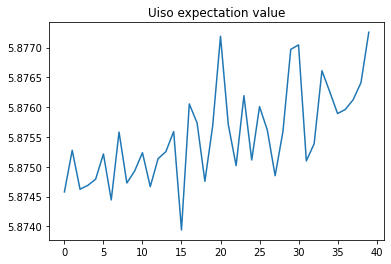

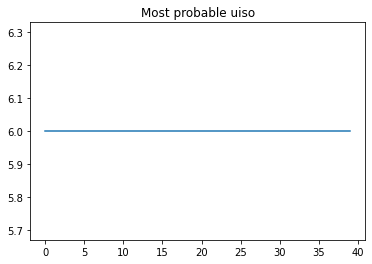

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan9/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan10/
Done! Added 6 images


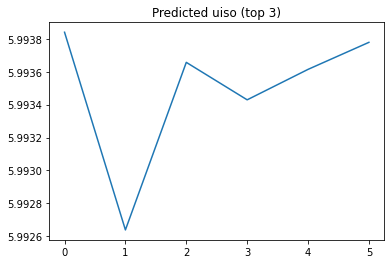

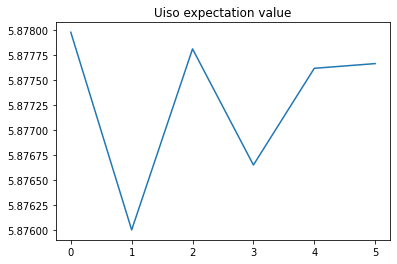

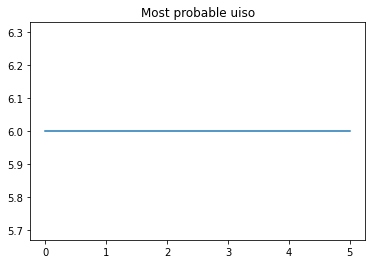

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan11/
Done! Added 41 images


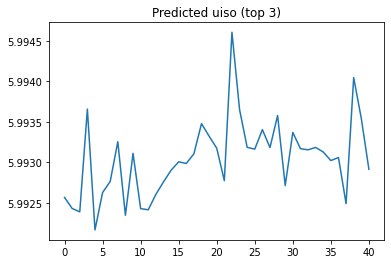

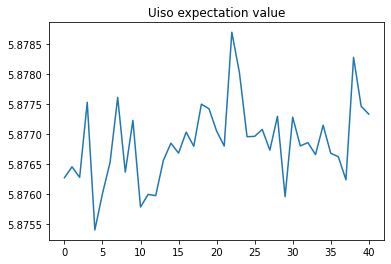

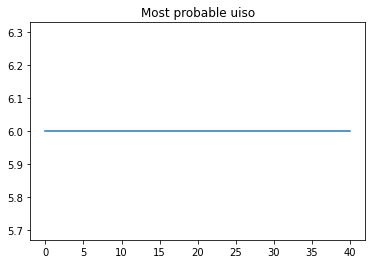

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan12/
Done! Added 5 images


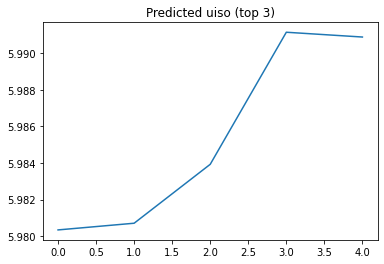

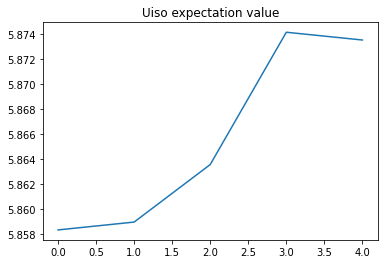

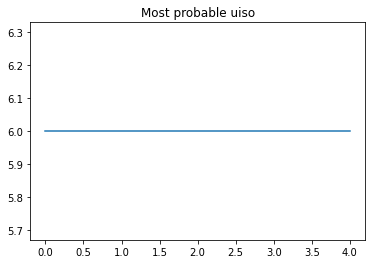

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan13/
Done! Added 41 images


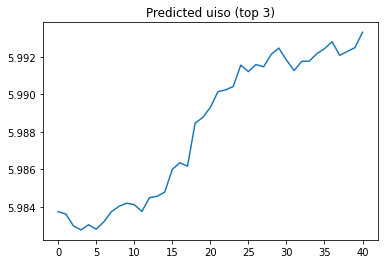

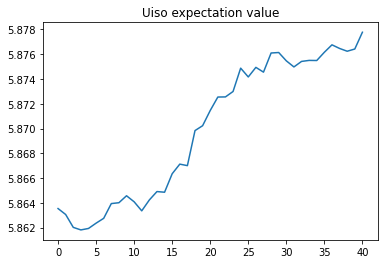

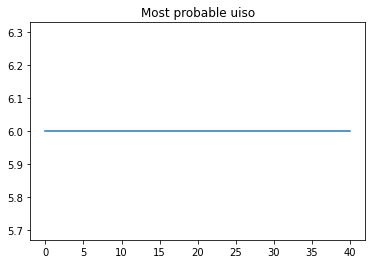

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-17/scans/scan14/
Done! Added 5 images


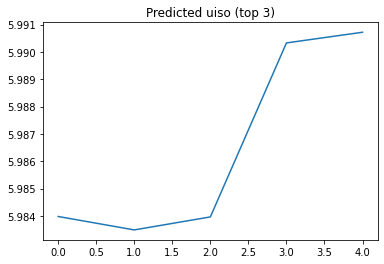

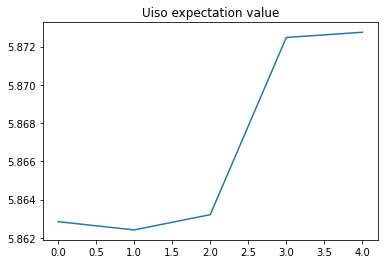

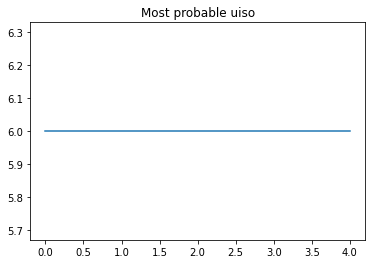

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan0/
Done! Added 9 images


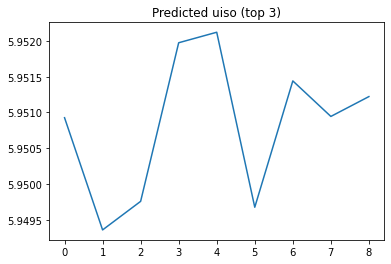

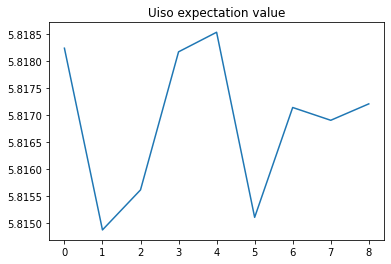

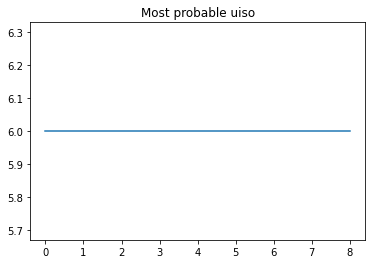

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan1/
Done! Added 11 images


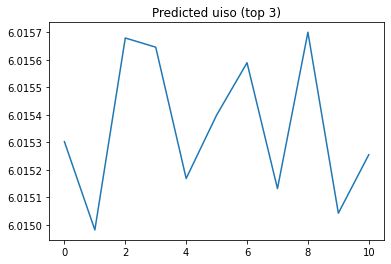

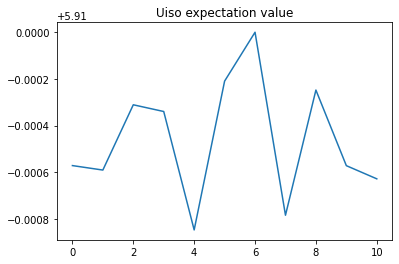

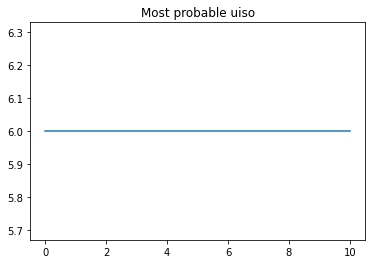

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan2/
Done! Added 13 images


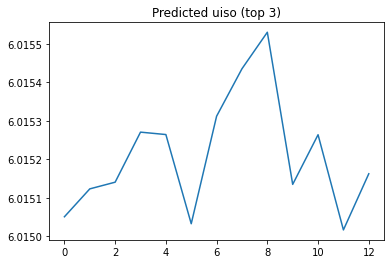

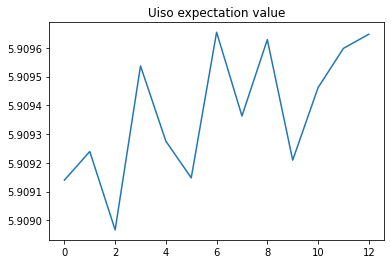

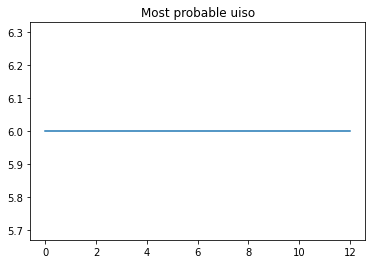

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan3/
Done! Added 15 images


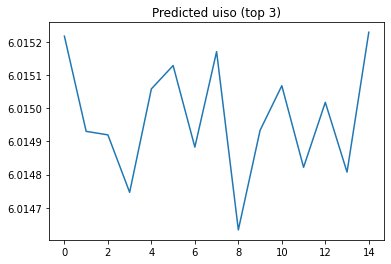

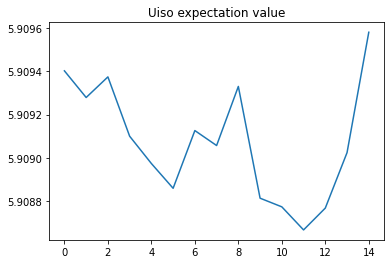

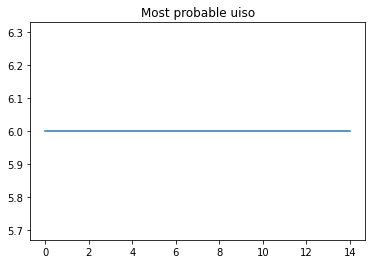

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan4/
Done! Added 16 images


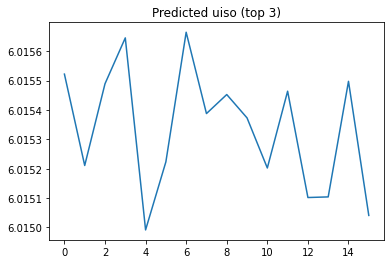

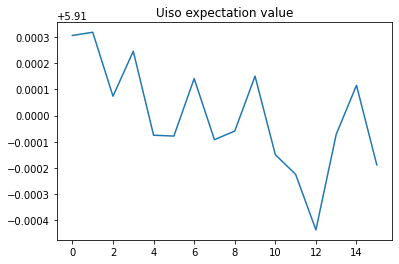

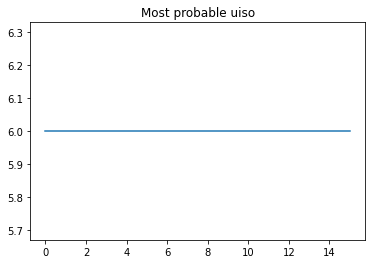

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan5/
Done! Added 24 images


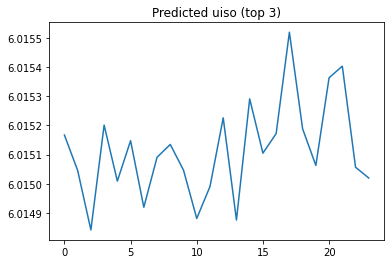

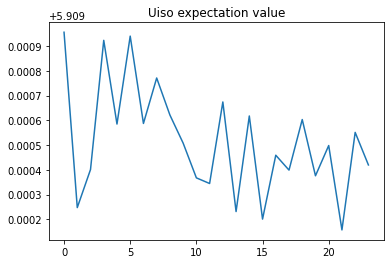

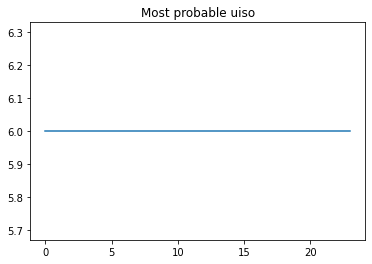

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan6/
Done! Added 22 images


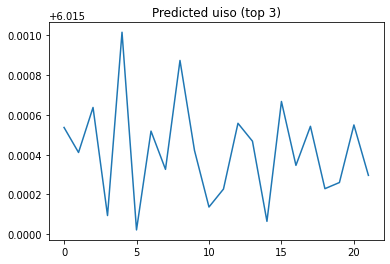

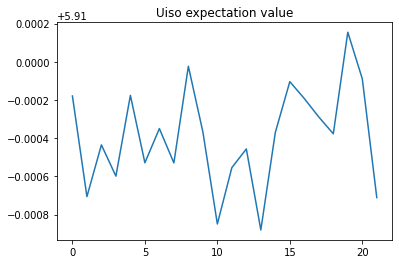

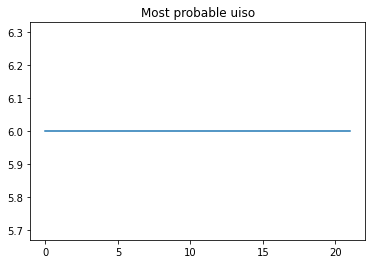

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan7/
Done! Added 1 images


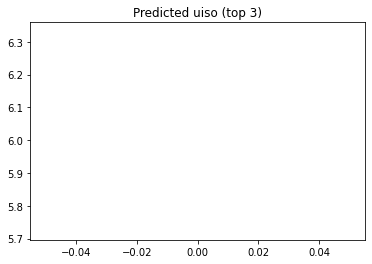

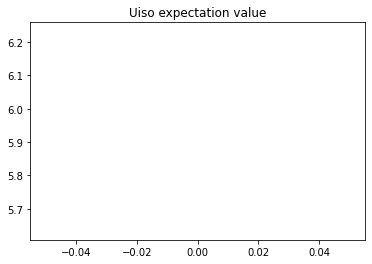

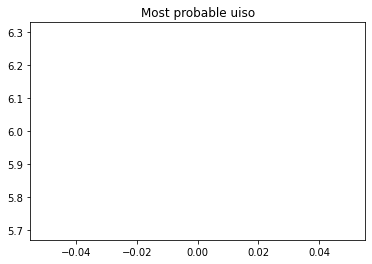

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan8/
Done! Added 1 images


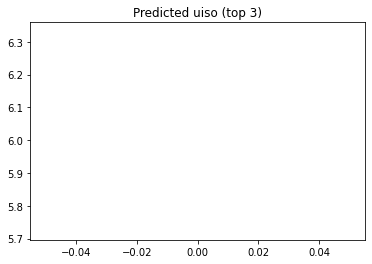

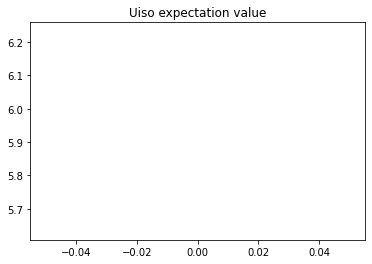

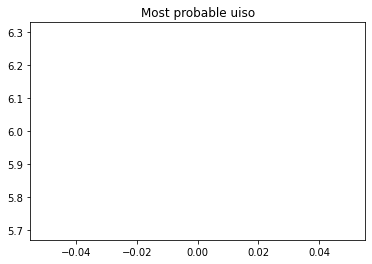

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan9/
Done! Added 1 images


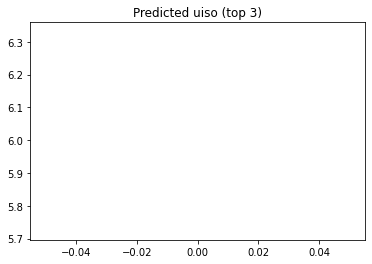

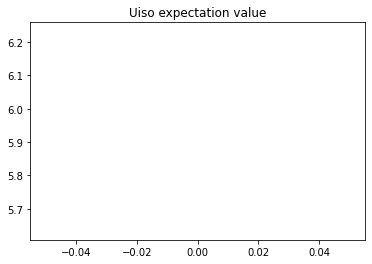

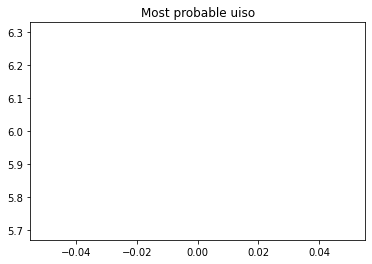

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan10/
Done! Added 24 images


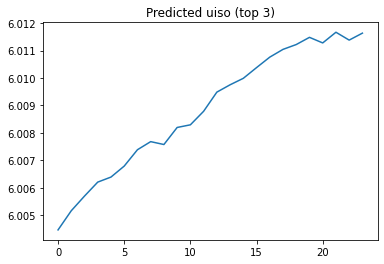

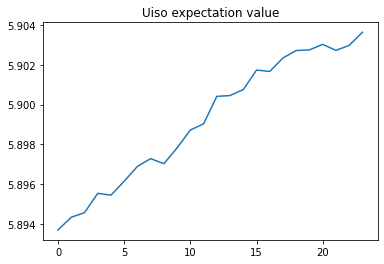

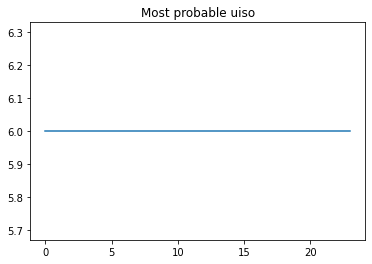

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan11/
----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan12/
Done! Added 25 images


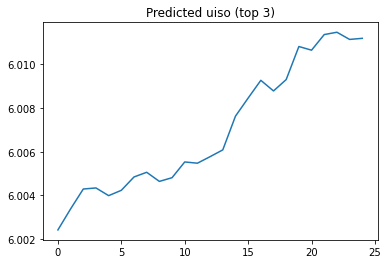

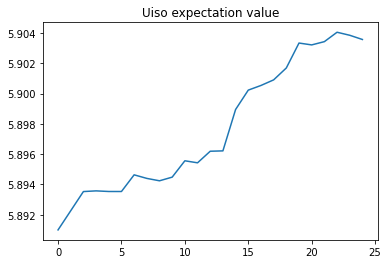

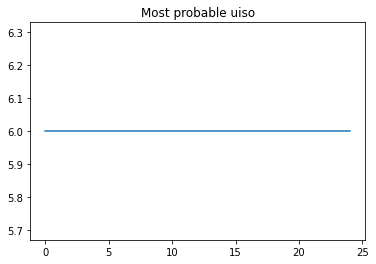

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan13/
Done! Added 25 images


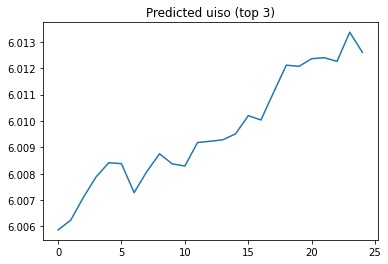

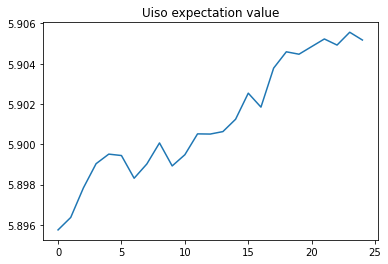

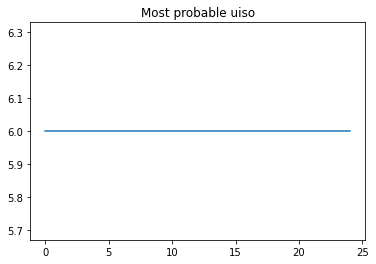

----------STARTING NEW TEST------
Directory name: /content/drive/MyDrive/Bismuth_Data_Processed/2021-02-21/scans/scan14/
Done! Added 25 images


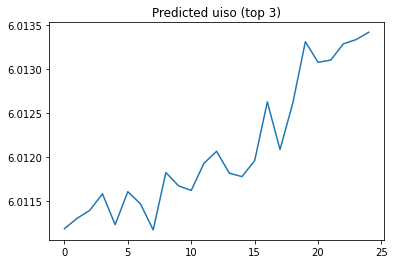

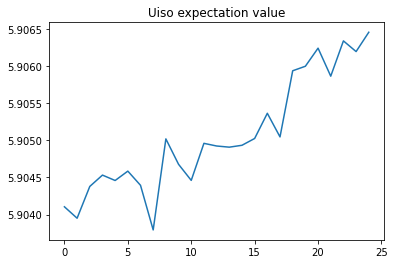

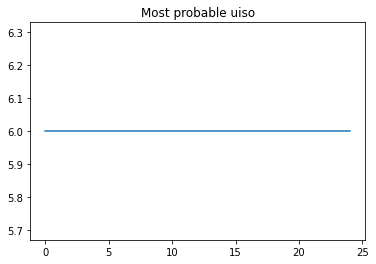

In [143]:
dates = [16,17,21]
dirs_to_open=range(0,15)
data_dir = '/content/drive/MyDrive/Bismuth_Data_Processed/'
#date = "2021-02-" + input("Which day's scan do you want to analyze?") + "/scans/scan"
#print("Date: " + date)
for date in dates:
  date = "2021-02-" + str(date) + "/scans/scan"
  for i in dirs_to_open:
    print("----------STARTING NEW TEST------")
    scan_num = str(i)#input("Which scan do you want to analyze?")
    dir_name = data_dir + date + scan_num + "/"
    print("Directory name: "+dir_name)
    #for file in os.scandir(dir_name):
    #  print(file.path)
    if os.path.exists(dir_name):
      file_name_array, data_dict = process_data(dir_name)
      file_name_array.sort()
      #print(file_name_array)
      data_arr = []
      for file_name in file_name_array:
        data_arr.append([data_dict[file_name],file_name])
      #print("This scan has: {} files".format(len(data_arr)))
      try:
        X_test,labels = zip(*data_arr)
        """
        plt.imshow(X_test[0],cmap='gray')
        plt.show()
        plt.imshow(images[0][0],cmap='gray')
        plt.show()
        """
        X_test_arr = np.expand_dims(np.array(X_test),-1)

        predictions = model.predict(X_test_arr)
        pred_vals = []
        max_pred = []
        max_pred_series_3 = []
        one_hot_conversion_vector = np.array([0,1,2,3,4,5,6,7,8,9,10])
        for prediction in predictions:

          index_list = np.argpartition(prediction, range(0,len(prediction)))[-3:]
          max_pred_vals_3 = []
          for index in index_list:
            max_pred_vals_3.append(prediction[index])
          
          max_pred_series_3.append((np.dot(index_list,max_pred_vals_3))/np.sum(max_pred_vals_3))

          max_pred.append(prediction.argmax())
          pred_vals.append(np.dot(prediction,one_hot_conversion_vector))

        plt.plot(max_pred_series_3)
        plt.title("Predicted uiso (top 3)")
        plt.show()  

        plt.plot(pred_vals)
        plt.title("Uiso expectation value")
        plt.show()
        
        plt.plot(max_pred)
        plt.title("Most probable uiso")
        plt.show()
        
        #interesting, only see max pred go up for max fluence... (not apparent on this iteration)
        #if i train for many epochs, maybe it overfits because of relatively small basis of original data points in dataset, but uiso trend actually reverses
      except:
        print("Couldn't load")

In [31]:
a = np.array([0,1,2,3,4,5,6,7,8,9,10])
b = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1])
np.random.shuffle(b)
print(b)
#b[np.argpartition(b, range(0,11))]
c = np.argpartition(b, range(0,11))[-3:]
d = []
for i in c:
  d.append(b[i])
d
#index_list = np.argpartition(prediction, range(0,len(prediction)))[-3:]


[1.1 0.4 0.6 0.1 0.5 1.  0.7 0.2 0.8 0.9 0.3]


[0.9, 1.0, 1.1]